In [1]:
%matplotlib inline

import sys, os
sys.path.insert(0, '../../../../vision/')
sys.path.append('../../../../../pytorch-segmentation-detection/')

# Use second GPU -pytorch-segmentation-detection- change if you want to use a first one
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from PIL import Image
from matplotlib import pyplot as plt

import torch
from torchvision import transforms
import torchvision
from torch.autograd import Variable
import pytorch_segmentation_detection.models.resnet_dilated as resnet_dilated
from pytorch_segmentation_detection.layers import GlobalAvgPool2d

import numpy as np
import torch.nn as nn

from pytorch_segmentation_detection.datasets.pascal_voc import PascalVOCSegmentation

#from adaptive_computation_time import ACT_Module

import pytorch_segmentation_detection.models.fcn as fcns
import pytorch_segmentation_detection.models.resnet_dilated as resnet_dilated
from pytorch_segmentation_detection.transforms import (ComposeJoint,
                                                       RandomHorizontalFlipJoint,
                                                       RandomScaleJoint,
                                                       CropOrPad,
                                                       ResizeAspectRatioPreserve,
                                                       RandomCropJoint,
                                                       Split2D)

from matplotlib import pyplot as plt

import numpy as np
import torch.optim as optim
from PIL import Image

from sklearn.metrics import confusion_matrix

def flatten_logits(logits, number_of_classes):
    """Flattens the logits batch except for the logits dimension"""
    
    logits_permuted = logits.permute(0, 2, 3, 1)
    logits_permuted_cont = logits_permuted.contiguous()
    logits_flatten = logits_permuted_cont.view(-1, number_of_classes)
    
    return logits_flatten

def flatten_annotations(annotations):
    
    return annotations.view(-1)

def get_valid_annotations_index(flatten_annotations, mask_out_value=255):
    
    return torch.squeeze( torch.nonzero((flatten_annotations != mask_out_value )), 1)

def adjust_learning_rate(optimizer, iteration):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    
    max_iteration = 10000.0
    
    multiplier = (1.0 - (iteration / max_iteration)) ** (0.9)
    
    lr = 0.0001 * multiplier
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


from pytorch_segmentation_detection.transforms import RandomCropJoint


number_of_classes = 21

labels = range(number_of_classes)




In [2]:
train_transform = ComposeJoint(
                [
                    RandomHorizontalFlipJoint(),
                    RandomCropJoint(crop_size=(513, 513)),
                    [transforms.ToTensor(), None],
                    [transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), None],
                    [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
                ])

path_to_VOC = '/media/peteflo/3TBbackup/pytorch-pretrained/VOC'

trainset = PascalVOCSegmentation(path_to_VOC,
                                 download=False,
                                 joint_transform=train_transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=4, drop_last=True)



valid_transform = ComposeJoint(
                [
                     [transforms.ToTensor(), None],
                     [transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), None],
                     [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
                ])


valset = PascalVOCSegmentation(path_to_VOC,
                               train=False,
                               download=False,
                               joint_transform=valid_transform)


valset_loader = torch.utils.data.DataLoader(valset, batch_size=1,
                                            shuffle=False, num_workers=2)

train_subset_sampler = torch.utils.data.sampler.SubsetRandomSampler(xrange(904))
train_subset_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=1,
                                                   sampler=train_subset_sampler,
                                                   num_workers=2)

# Define the validation function to track MIoU during the training
def validate():
    
    fcn.eval()
    
    overall_confusion_matrix = None

    for image, annotation in valset_loader:

        image = Variable(image.cuda())
        logits = fcn(image)

        # First we do argmax on gpu and then transfer it to cpu
        logits = logits.data
        _, prediction = logits.max(1)
        prediction = prediction.squeeze(1)

        prediction_np = prediction.cpu().numpy().flatten()
        annotation_np = annotation.numpy().flatten()

        # Mask-out value is ignored by default in the sklearn
        # read sources to see how that was handled

        current_confusion_matrix = confusion_matrix(y_true=annotation_np,
                                                    y_pred=prediction_np,
                                                    labels=labels)

        if overall_confusion_matrix is None:


            overall_confusion_matrix = current_confusion_matrix
        else:

            overall_confusion_matrix += current_confusion_matrix
    
    
    intersection = np.diag(overall_confusion_matrix)
    ground_truth_set = overall_confusion_matrix.sum(axis=1)
    predicted_set = overall_confusion_matrix.sum(axis=0)
    union =  ground_truth_set + predicted_set - intersection

    intersection_over_union = intersection / union.astype(np.float32)
    mean_intersection_over_union = np.mean(intersection_over_union)
    
    fcn.train()

    return mean_intersection_over_union


def validate_train():
    
    fcn.eval()
    
    overall_confusion_matrix = None

    for image, annotation in train_subset_loader:

        image = Variable(image.cuda())
        logits = fcn(image)

        # First we do argmax on gpu and then transfer it to cpu
        logits = logits.data
        _, prediction = logits.max(1)
        prediction = prediction.squeeze(1)

        prediction_np = prediction.cpu().numpy().flatten()
        annotation_np = annotation.numpy().flatten()

        # Mask-out value is ignored by default in the sklearn
        # read sources to see how that was handled

        current_confusion_matrix = confusion_matrix(y_true=annotation_np,
                                                    y_pred=prediction_np,
                                                    labels=labels)

        if overall_confusion_matrix is None:


            overall_confusion_matrix = current_confusion_matrix
        else:

            overall_confusion_matrix += current_confusion_matrix
    
    
    intersection = np.diag(overall_confusion_matrix)
    ground_truth_set = overall_confusion_matrix.sum(axis=1)
    predicted_set = overall_confusion_matrix.sum(axis=0)
    union =  ground_truth_set + predicted_set - intersection

    intersection_over_union = intersection / union.astype(np.float32)
    mean_intersection_over_union = np.mean(intersection_over_union)
    
    fcn.train()

    return mean_intersection_over_union

<IPython.core.display.Javascript object>


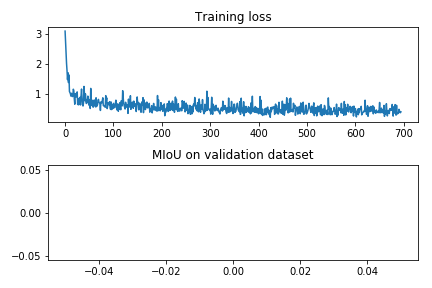

In [3]:
%matplotlib notebook

from matplotlib import pyplot as plt


# Create the training plot
loss_current_iteration = 0
loss_history = []
loss_iteration_number_history = []

validation_current_iteration = 0
validation_history = []
validation_iteration_number_history = []

train_validation_current_iteration = 0
train_validation_history = []
train_validation_iteration_number_history = []
 
f, (loss_axis, validation_axis) = plt.subplots(2, 1)

loss_axis.plot(loss_iteration_number_history, loss_history)
validation_axis.plot(validation_iteration_number_history, validation_history, 'b',
                     train_validation_iteration_number_history, train_validation_history, 'r')

loss_axis.set_title('Training loss')
validation_axis.set_title('MIoU on validation dataset')

plt.tight_layout()

In [ ]:
fcn = resnet_dilated.Resnet34_8s(num_classes=21)
fcn.cuda()
fcn.train()

criterion = nn.CrossEntropyLoss(size_average=False).cuda()

optimizer = optim.Adam(fcn.parameters(), lr=0.0001, weight_decay=0.0001)

/usr/local/lib/python2.7/dist-packages/torch/nn/modules/module.py:482: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  own_state[name].copy_(param)


In [ ]:
import time

best_validation_score = 0

iter_size = 20

for epoch in range(130):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        start = time.time()
        
        # get the inputs
        img, anno = data
        
        # We need to flatten annotations and logits to apply index of valid
        # annotations. All of this is because pytorch doesn't have tf.gather_nd()
        anno_flatten = flatten_annotations(anno)
        index = get_valid_annotations_index(anno_flatten, mask_out_value=255)
        anno_flatten_valid = torch.index_select(anno_flatten, 0, index)

        # wrap them in Variable
        # the index can be acquired on the gpu
        img, anno_flatten_valid, index = Variable(img.cuda()), Variable(anno_flatten_valid.cuda()), Variable(index.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()
        
        adjust_learning_rate(optimizer, loss_current_iteration)

        # forward + backward + optimize
        logits = fcn(img)
        logits_flatten = flatten_logits(logits, number_of_classes=21)
        logits_flatten_valid = torch.index_select(logits_flatten, 0, index)
        
        loss = criterion(logits_flatten_valid, anno_flatten_valid)# + ponder_cost.sum() * 0.1
        loss.backward()
        optimizer.step()
        
        print time.time() - start, " seconds on gpu 0"

        # print statistics
        running_loss += (loss.data[0] / logits_flatten_valid.size(0)) 
        if i % 2 == 1:
            
            
            loss_history.append(running_loss / 2)
            loss_iteration_number_history.append(loss_current_iteration)
            
            loss_current_iteration += 1
            
            loss_axis.lines[0].set_xdata(loss_iteration_number_history)
            loss_axis.lines[0].set_ydata(loss_history)

            loss_axis.relim()
            loss_axis.autoscale_view()
            loss_axis.figure.canvas.draw()
            
            running_loss = 0.0
            
        
            
    current_validation_score = validate()
    validation_history.append(current_validation_score)
    validation_iteration_number_history.append(validation_current_iteration)

    validation_current_iteration += 1

    validation_axis.lines[0].set_xdata(validation_iteration_number_history)
    validation_axis.lines[0].set_ydata(validation_history)



    current_train_validation_score = validate_train()
    train_validation_history.append(current_train_validation_score)
    train_validation_iteration_number_history.append(train_validation_current_iteration)

    train_validation_current_iteration += 1

    validation_axis.lines[1].set_xdata(train_validation_iteration_number_history)
    validation_axis.lines[1].set_ydata(train_validation_history)


    validation_axis.relim()
    validation_axis.autoscale_view()
    validation_axis.figure.canvas.draw()

    # Save the model if it has a better MIoU score.
    if current_validation_score > best_validation_score:

        torch.save(fcn.state_dict(), 'resnet_34_8s.pth')
        best_validation_score = current_validation_score
        print(best_validation_score)
    
        
                

print('Finished Training')

/usr/local/lib/python2.7/dist-packages/torch/nn/functional.py:1423: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


1.45186901093  seconds on gpu 0
0.891056776047  seconds on gpu 0
0.863487958908  seconds on gpu 0
0.838878154755  seconds on gpu 0
0.841158866882  seconds on gpu 0
0.849801063538  seconds on gpu 0
0.840535163879  seconds on gpu 0
0.837509870529  seconds on gpu 0
0.853203058243  seconds on gpu 0
0.841886043549  seconds on gpu 0
0.840454101562  seconds on gpu 0
0.851950883865  seconds on gpu 0
0.848829030991  seconds on gpu 0
0.852469921112  seconds on gpu 0
0.857550144196  seconds on gpu 0
0.853894948959  seconds on gpu 0
0.845136165619  seconds on gpu 0
0.851886987686  seconds on gpu 0
0.841598987579  seconds on gpu 0
0.857703208923  seconds on gpu 0
0.844288110733  seconds on gpu 0
0.852849006653  seconds on gpu 0
0.888412952423  seconds on gpu 0
0.845176935196  seconds on gpu 0
0.859823942184  seconds on gpu 0
0.850133895874  seconds on gpu 0
0.844023227692  seconds on gpu 0
0.856565952301  seconds on gpu 0
0.841814994812  seconds on gpu 0
0.845491886139  seconds on gpu 0
0.862251043

0.860057830811  seconds on gpu 0
0.964531898499  seconds on gpu 0
0.90602517128  seconds on gpu 0
0.962373971939  seconds on gpu 0
0.939778089523  seconds on gpu 0
0.924935102463  seconds on gpu 0
0.922434806824  seconds on gpu 0
0.86814904213  seconds on gpu 0
0.904554843903  seconds on gpu 0
0.895714998245  seconds on gpu 0
0.91261100769  seconds on gpu 0
0.947912931442  seconds on gpu 0
0.927820205688  seconds on gpu 0
0.904790878296  seconds on gpu 0
0.875880002975  seconds on gpu 0
0.876556873322  seconds on gpu 0
0.867789983749  seconds on gpu 0
0.890860795975  seconds on gpu 0
0.879507064819  seconds on gpu 0
0.86301612854  seconds on gpu 0
0.878463029861  seconds on gpu 0
0.85813498497  seconds on gpu 0
0.91255903244  seconds on gpu 0
0.944656848907  seconds on gpu 0
0.961632013321  seconds on gpu 0
0.924918889999  seconds on gpu 0
0.904423952103  seconds on gpu 0
0.864659786224  seconds on gpu 0
0.939491987228  seconds on gpu 0
0.924652814865  seconds on gpu 0
0.928800821304  

0.897573947906  seconds on gpu 0
0.892470836639  seconds on gpu 0
0.896413087845  seconds on gpu 0
0.887250900269  seconds on gpu 0
0.870464086533  seconds on gpu 0
0.886073827744  seconds on gpu 0
0.949404001236  seconds on gpu 0
0.944839000702  seconds on gpu 0
0.932921886444  seconds on gpu 0
0.922616958618  seconds on gpu 0
0.883035182953  seconds on gpu 0
0.93119597435  seconds on gpu 0
0.937906980515  seconds on gpu 0
0.929371118546  seconds on gpu 0
0.90830206871  seconds on gpu 0
0.888052940369  seconds on gpu 0
0.864933013916  seconds on gpu 0
0.895015954971  seconds on gpu 0
0.866530179977  seconds on gpu 0
0.854367017746  seconds on gpu 0
0.902909040451  seconds on gpu 0
0.861886024475  seconds on gpu 0
0.894614934921  seconds on gpu 0
0.855261087418  seconds on gpu 0
0.891288042068  seconds on gpu 0
0.947207927704  seconds on gpu 0
0.932214021683  seconds on gpu 0
0.91752910614  seconds on gpu 0
0.890670061111  seconds on gpu 0
0.895323991776  seconds on gpu 0
0.87589001655

0.91094994545  seconds on gpu 0
0.880522012711  seconds on gpu 0
0.936089038849  seconds on gpu 0
0.9304459095  seconds on gpu 0
0.903213977814  seconds on gpu 0
0.867378950119  seconds on gpu 0
0.886831998825  seconds on gpu 0
0.882627010345  seconds on gpu 0
0.896058082581  seconds on gpu 0
0.931515932083  seconds on gpu 0
0.940176963806  seconds on gpu 0
0.937521934509  seconds on gpu 0
0.936605215073  seconds on gpu 0
0.886348962784  seconds on gpu 0
0.89107298851  seconds on gpu 0
0.860399007797  seconds on gpu 0
0.901630878448  seconds on gpu 0
0.914962053299  seconds on gpu 0
0.891957044601  seconds on gpu 0
0.858505964279  seconds on gpu 0
0.926730871201  seconds on gpu 0
0.871748924255  seconds on gpu 0
0.889779090881  seconds on gpu 0
0.887036085129  seconds on gpu 0
0.856624126434  seconds on gpu 0
0.92739200592  seconds on gpu 0
0.890902996063  seconds on gpu 0
0.858580112457  seconds on gpu 0
0.877830982208  seconds on gpu 0
0.882190942764  seconds on gpu 0
0.892898082733 

0.866706132889  seconds on gpu 0
0.901432037354  seconds on gpu 0
0.882152080536  seconds on gpu 0
0.894217014313  seconds on gpu 0
0.870714902878  seconds on gpu 0
0.866351127625  seconds on gpu 0
0.886639118195  seconds on gpu 0
0.877614021301  seconds on gpu 0
0.906033992767  seconds on gpu 0
0.926409006119  seconds on gpu 0
0.933372974396  seconds on gpu 0
0.908872127533  seconds on gpu 0
0.880458116531  seconds on gpu 0
0.862832784653  seconds on gpu 0
0.872740030289  seconds on gpu 0
0.886166095734  seconds on gpu 0
0.859965801239  seconds on gpu 0
0.901006937027  seconds on gpu 0
0.89901804924  seconds on gpu 0
0.860017061234  seconds on gpu 0
0.896398067474  seconds on gpu 0
0.928722143173  seconds on gpu 0
0.926297903061  seconds on gpu 0
0.920307159424  seconds on gpu 0
0.889282941818  seconds on gpu 0
0.87471985817  seconds on gpu 0
0.887320995331  seconds on gpu 0
0.861721992493  seconds on gpu 0
0.853327035904  seconds on gpu 0
0.900989055634  seconds on gpu 0
0.8854019641

0.884495019913  seconds on gpu 0
0.861320018768  seconds on gpu 0
0.899528026581  seconds on gpu 0
0.854599952698  seconds on gpu 0
0.898765087128  seconds on gpu 0
0.879139900208  seconds on gpu 0
0.861066102982  seconds on gpu 0
0.889698028564  seconds on gpu 0
0.89186000824  seconds on gpu 0
0.866939067841  seconds on gpu 0
0.923283815384  seconds on gpu 0
0.863648891449  seconds on gpu 0
0.903362989426  seconds on gpu 0
0.924615859985  seconds on gpu 0
0.939750909805  seconds on gpu 0
0.929581880569  seconds on gpu 0
0.88091802597  seconds on gpu 0
0.888965845108  seconds on gpu 0
0.868176937103  seconds on gpu 0
0.921653985977  seconds on gpu 0
0.8833091259  seconds on gpu 0
0.891868829727  seconds on gpu 0
0.870985031128  seconds on gpu 0
0.896780014038  seconds on gpu 0
0.856008768082  seconds on gpu 0
0.887460947037  seconds on gpu 0
0.903557062149  seconds on gpu 0
0.865797996521  seconds on gpu 0
0.91456580162  seconds on gpu 0
0.944179058075  seconds on gpu 0
0.930620908737 